In [2]:
from math import sqrt

import torch as th
import cvxpy as cp
import numpy as np
from qutip import fidelity, Qobj

from quantum import coherent_ket, coherent_dm
from utils import grid_points, random_stiefel, unstack, plot_matrix

In [3]:
def reconstruct_povm(probes, P_true, lam=0.0):
    """
    Reconstruct POVM elements E_i from true probabilities P_true and known probe states,
    with optional L1 regularization.
    
    Args:
        probes: list or array of density matrices (U x N x N)
        P_true: matrix of true probabilities (M x U)
        lam: regularization strength (lambda >= 0)
        
    Returns:
        list of POVM elements (E_i) as numpy arrays
    """
    U = len(probes)         # number of probes
    N = probes[0].shape[0]  # Hilbert space dimension
    M = P_true.shape[0]     # number of POVM elements

    # CVXPY Hermitian variables for POVM elements
    E = [cp.Variable((N, N), hermitian=True) for _ in range(M)]

    # Constraints: PSD and completeness
    constraints = [E_i >> 0 for E_i in E]
    constraints += [cp.sum(E) == np.eye(N)]

    # Construct predicted probability matrix
    rows = []
    for i in range(M):
        row = [cp.real(cp.trace(E[i] @ probes[j])) for j in range(U)]
        rows.append(cp.hstack(row))
    P_pred = cp.vstack(rows)

    # L1 regularization term (sum of elementwise abs values)
    reg = cp.sum([cp.norm1(E_i) for E_i in E])

    # Objective function: least squares + lambda * L1
    objective = cp.Minimize(cp.sum_squares(P_pred - P_true) + lam * reg)

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    return [E_i.value for E_i in E]

In [4]:
N = 50
M = 50
lam = 1e-5

num_probes = 30
max_amp = sqrt(9)  # max coordinate in phase space that will be spanned in one direction is max_amp^2

# generate num_probes^2 state probes each from circles of increasing radius
# complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0.1, max_amp, num_probes) ]).flatten()
complex_amps = grid_points(num_probes, xlim=(-max_amp, max_amp), ylim=(-max_amp, max_amp), dtype=th.complex128)

probes_ket = th.vstack([coherent_ket(alpha, N)  for alpha in complex_amps ])

print(f"Shape of probes is: {list(probes_ket.shape)} should be {[num_probes**2, N]}.")

Shape of probes is: [900, 50] should be [900, 50].


In [5]:
# random POVM
true_povm_factors = random_stiefel(M*N, N) 
true_povm_factors = unstack(true_povm_factors, M=M, N=N) 
true_povm = [E.H @ E for E in true_povm_factors]  # true POVM for data generation

# binary detection POVM
# M = 2
# E1 = th.diag( th.tensor([1.0] + [0.0]*(N-1), dtype=th.complex128) )
# E2 = th.eye(N) - E1
# true_povm = [E1, E2]


targets = th.einsum("bi,mij,bj->bm", probes_ket.conj(), th.stack(true_povm), probes_ket).real.numpy().T
probes = th.vstack([coherent_dm(alpha, N)  for alpha in complex_amps ]).numpy().reshape(num_probes**2, N, N)

print(f"Shape of targets is: {list(targets.shape)} should be {[M, num_probes**2]}.")
print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes**2, N, N]}.")

Shape of targets is: [50, 900] should be [50, 900].
Shape of probes is: [900, 50, 50] should be [900, 50, 50].


In [ ]:
pred_povm = np.array(reconstruct_povm(probes, targets, lam=lam))

/home/amanuelant/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:167: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/amanuelant/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:173: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


In [ ]:
print(pred_povm.shape)

(3, 50, 50)


In [ ]:
pred_povm = th.tensor(pred_povm, dtype=th.complex128)
true_povm = th.stack(true_povm)

In [ ]:
print("Fidelities:", [ th.real(fidelity(Qobj(pred_povm[i]), Qobj(true_povm[i]))**2 / (th.trace(true_povm[i])*th.trace(pred_povm[i]))).item() for i in range(M) ])
print("Rel errors:", [ 100*th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item() / th.linalg.norm(true_povm[i], ord="fro").item() for i in range(M) ])
print("Dist: ", sqrt(sum([ th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item()**2 for i in range(M) ])) )
pred_probs = th.einsum("bi,mij,bj->bm", probes_ket.conj(), pred_povm, probes_ket).real
#print(th.sum((pred_probs - targets.T) ** 2).item())

NameError: name 'M' is not defined

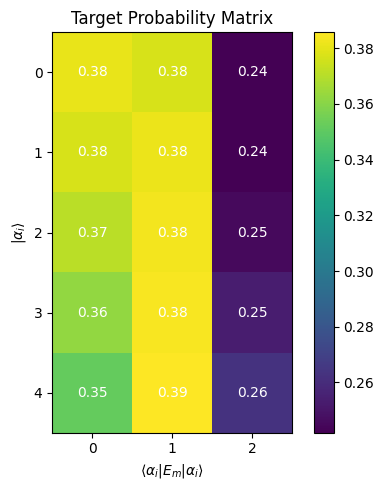

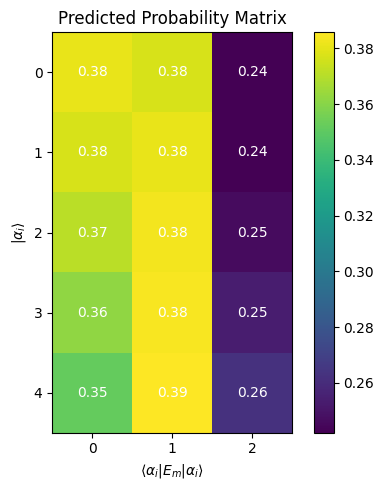

In [ ]:
plot_matrix(
    targets.T[:5],
    title="Target Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)

plot_matrix(
    pred_probs.cpu().numpy()[:5],
    title="Predicted Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)